# Example 2: Simulating RFs for FN07A

In this example we generate plane wave seismograms and P receiver functions for station FN07A. This example follows that of Figure 11 in [Audet (2016)](#references). 

Start by importing the necessary modules

In [1]:
from obspy.core import Stream, read
from telewavesim import utils as ut
from telewavesim import wiggle as wg
import csv

Select the model file (here we choose F2, but other models are available in folder):

In [2]:
modfile = 'model_F1.txt'

Select the type of incident wave - options are `'P'`, `'SV'`, `'SH'`, or `'Si'`, which is an isotropic S-wave source:

In [3]:
wvtype = 'P'

Next we use global variables to define the desired time series. Be careful to use a total length of time large enough to avoid wrap around effects. Sometimes if you see signals arriving at aberrant times, try with either a greater number of samples or higher `dt`.

In [4]:
npts = 1551*2 # Number of samples
dt = 0.1   # Sample distance in seconds

Here we choose to model seismograms for an ocean-bottom station, so we specify the deployment depth. 

<p class="alert alert-warning">
  <strong>Warning!</strong> This one is required for OBS simulations. Otherwise an Exception will be raised and the code will stop.
</p>

In [5]:
dp = 154. # Deployment depth below sea level in meters

The parameters (P-wave velocity and density) of the water layer have default values of 1500 m/s and 1027 kg/m^3, respectively, but these values can be changed here:

In [6]:
c = 1.5      # P-wave velocity in salt water (km/s)
rhof = 1027. # Density of salt water (kg/m^3)

Now specify the parameters of the incident wavefield in terms of a horizontal slowness and back-azimuth.

In [7]:
# Start with empty list
slowness = []

# Read in values calculated from Tutorial 4 in file ../TUTORIAL4/RF_FOLDER/baz_slow.csv
with open('../TUTORIAL4/RF_FOLDER/baz_slow.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # skip first line
    for row in reader:
        slowness.append(float(row[1]))

# Back-azimuth direction in degrees (has no influence if model is isotropic)
baz = 0.    

Read the model parameters from the model file and return a Model object. Up to here, the steps could have been performed in no particular order, except the name of the file that needs to be defined before the call to `read_model()`.

In [8]:
model = ut.read_model(modfile)

# Print out Vp variable to check values
print(model.vp)

[3.8  6.08 6.65 8.1 ]


Here we generate the plane wave seismograms by calling the `plane` module from the `utils` module and storing the output in a 3-component stream oriented in North, East and Vertical directions. This is also where we specify that we are interested in OBS synthetic data, i.e., including effects from an overlying water layer. The `obs` boolean variable defaults to `False`, so use the following call with argument `obs=True`.

Because we have several slowness values to evaluate, we run all the code in one cell

In [9]:
radial = Stream()
transverse = Stream()
for slow in slowness:
    trxyz = ut.run_plane(model, slow, npts, dt, baz=baz, wvtype=wvtype,
                         obs=True, dp=dp, c=c, rhof=rhof)
    tfs = ut.tf_from_xyz(trxyz, pvh=False)
    radial.append(tfs[0])
    transverse.append(tfs[1])

radial.filter('bandpass', freqmin=0.1, freqmax=0.5, corners=2, zerophase=True)
transverse.filter('bandpass', freqmin=0.1, freqmax=0.5, corners=2, zerophase=True)

10 Trace(s) in Stream:
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples
...E | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:05:10.100000Z | 10.0 Hz, 3102 samples


Stacking ALL traces in streams

Plotting Wiggles by slow


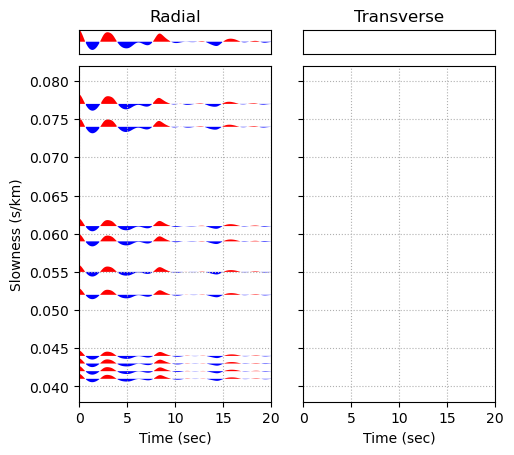

In [10]:
# Stack over all traces
radial_stack, transverse_stack = ut.stack_all(radial, transverse, pws=False)

# Plot as wiggles
wg.rf_wiggles_baz(
    radial,
    transverse,
    radial_stack,
    transverse_stack,
    'FN07A',
    btyp='slow',
    scale=5.e-2,
    tmin=0.,
    tmax=20.)


Plotting Wiggles by slow


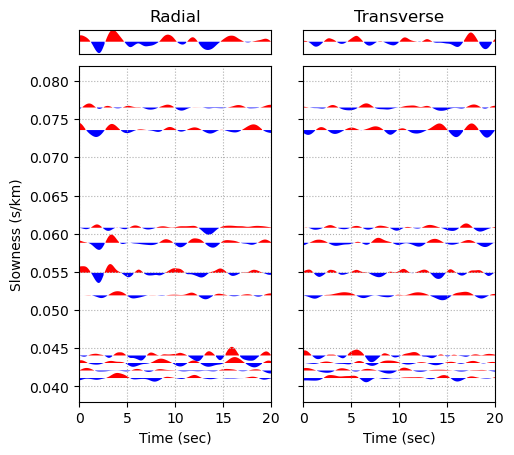

In [14]:
# Read stacked traces from RfPy
path = '../TUTORIAL4/RF_FOLDER/'
radial_stack_FN07A = read(path + 'FN07A.RFR.stack.sac')[0]
transverse_stack_FN07A = read(path + 'FN07A.RFT.stack.sac')[0]

# Read all traces sorted by slowness
radial_stream_FN07A = read(path + 'FN07A.RFR.*.*.sac')
transverse_stream_FN07A = read(path + 'FN07A.RFT.*.*.sac')

# Update trace stats with slowness value
for trR, trT in zip(radial_stream_FN07A, transverse_stream_FN07A):
    trR.stats.slow = trR.stats.sac.user0
    trT.stats.slow = trT.stats.sac.user0
    
# Plot as wiggles
wg.rf_wiggles_baz(
    radial_stream_FN07A,
    transverse_stream_FN07A,
    radial_stack_FN07A,
    transverse_stack_FN07A,
    'FN07A',
    btyp='slow',
    scale=5.e-2,
    tmin=0.,
    tmax=20.)

Voilà! 

You can play with these parameters and change the model file (while respecting its format) and see how the seismograms change. You can also compare the run time difference between the Python and Fortran implementations, but for this simple case with only one plane wave simulation, the difference is minor.

## References
* Audet, P. (2016). Receiver functions using OBS data: promises and limitations from numerical modelling and examples from the Cascadia Initiative. Geophysical Journal International, 205, 1740-1755. https://doi.org/10.1093/gji/ggw111